In [1]:
import pandas as pd

#load from dataset folder
df = pd.read_excel('dataset/SolarForecast_20150701-20150731.xls')

In [2]:
df.head()

,Period: 01/07/2015 to 31/07/2015,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Monitored selection: Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DateTime,Most recent forecast [MW],Day-Ahead forecast [MW],Week-Ahead forecast [MW],Real-time Upscaled Measurement [MW],Corrected Upscaled Measurement [MW],Monitored Capacity [MWp],Day-Ahead forecast (11h00) [MW]
3,01/07/2015 00:00,0,NaN,NaN,0,0,2915.88,0
4,01/07/2015 00:15,0,NaN,NaN,0,0,2915.88,0


In [3]:
# Rename columns for easier access
df.columns = ["DateTime", "Most_Recent_Forecast_MW", "Day_Ahead_Forecast_MW", "Week_Ahead_Forecast_MW", 
              "Real_Time_Measurement_MW", "Corrected_Measurement_MW", "Monitored_Capacity_MWp", "Day_Ahead_11h00_MW"]

# Drop the first two rows which contain metadata
df = df.iloc[2:].reset_index(drop=True)

# Convert DateTime column to actual datetime format
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%d/%m/%Y %H:%M", errors='coerce')

# Convert power columns to numeric values
power_columns = ["Real_Time_Measurement_MW", "Corrected_Measurement_MW", "Most_Recent_Forecast_MW"]
df[power_columns] = df[power_columns].apply(pd.to_numeric, errors="coerce")

# Display the cleaned dataset
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Solar Power Output Data", dataframe=df)


Solar Power Output Data


In [4]:
# Display the first few values of the DateTime column to check for format issues
df["DateTime"].head(10)

0                   NaT
1   2015-07-01 00:00:00
2   2015-07-01 00:15:00
3   2015-07-01 00:30:00
4   2015-07-01 00:45:00
5   2015-07-01 01:00:00
6   2015-07-01 01:15:00
7   2015-07-01 01:30:00
8   2015-07-01 01:45:00
9   2015-07-01 02:00:00
Name: DateTime, dtype: datetime64[ns]

In [5]:
# Remove the incorrect header row
df = df.iloc[1:].reset_index(drop=True)

# Convert DateTime column to actual datetime format
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%d/%m/%Y %H:%M")

# Convert power columns to numeric values
df[power_columns] = df[power_columns].apply(pd.to_numeric, errors="coerce")

# Display the cleaned dataset
tools.display_dataframe_to_user(name="Cleaned Solar Power Data", dataframe=df)

Cleaned Solar Power Data


In [6]:
df["DateTime"].head(10)

0   2015-07-01 00:00:00
1   2015-07-01 00:15:00
2   2015-07-01 00:30:00
3   2015-07-01 00:45:00
4   2015-07-01 01:00:00
5   2015-07-01 01:15:00
6   2015-07-01 01:30:00
7   2015-07-01 01:45:00
8   2015-07-01 02:00:00
9   2015-07-01 02:15:00
Name: DateTime, dtype: datetime64[ns]

In [7]:
# check if data has missing values
df.isnull().sum()

DateTime                       0
Most_Recent_Forecast_MW        0
Day_Ahead_Forecast_MW       2976
Week_Ahead_Forecast_MW      2976
Real_Time_Measurement_MW       0
Corrected_Measurement_MW       0
Monitored_Capacity_MWp         0
Day_Ahead_11h00_MW             0
dtype: int64

In [8]:
# count the number of days in dataframe
df["DateTime"].dt.date.nunique()

print("The number of days in the dataset is:", df["DateTime"].dt.date.nunique())

The number of days in the dataset is: 31


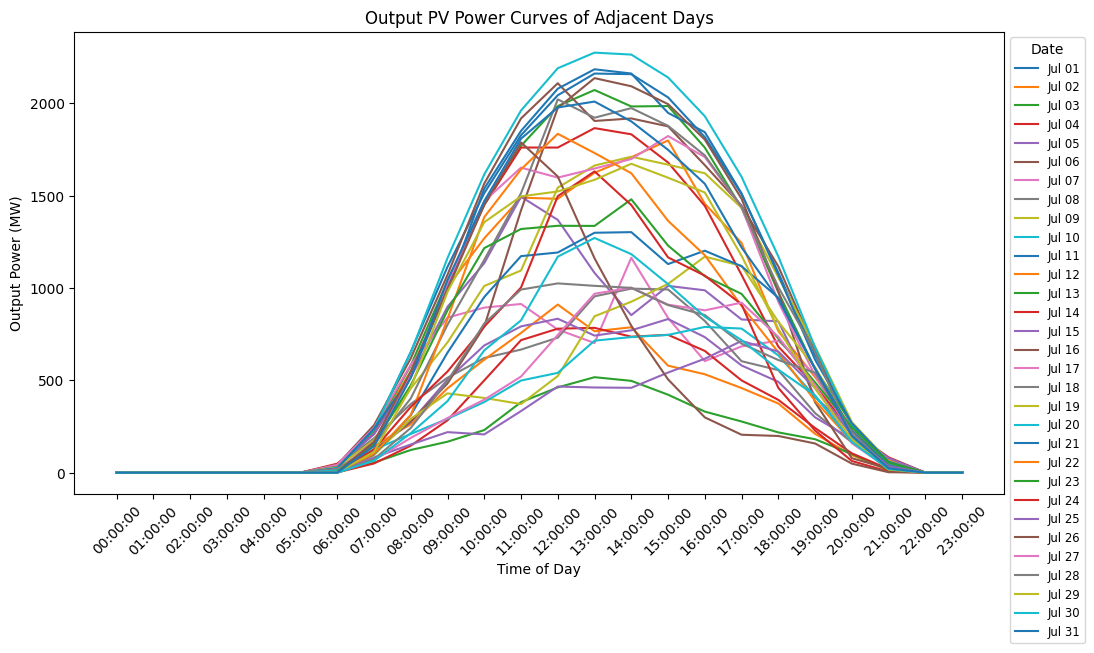

In [9]:
import matplotlib.pyplot as plt

# Select a range of dates for plotting
df["Date"] = df["DateTime"].dt.date
df["Time"] = df["DateTime"].dt.strftime('%H:%M:%S')

# Filter all days in the dataset
selected_days = df["Date"].unique()[:]
df_subset = df[df["Date"].isin(selected_days)]

# Filter the dataframe to include only rows where the time is on the hour
df_subset = df_subset[df_subset["Time"].str.endswith(':00:00')]

# Pivot data to have time on x-axis and days as separate lines
pivot_df = df_subset.pivot(index="Time", columns="Date", values="Real_Time_Measurement_MW")

# Plot Figure 1: Output PV Power Curves of Adjacent Days
plt.figure(figsize=(12, 6))
for day in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[day], label=day.strftime('%b %d'))

# Formatting the plot
plt.xlabel("Time of Day")
plt.ylabel("Output Power (MW)")
plt.title("Output PV Power Curves of Adjacent Days")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title="Date", bbox_to_anchor=(1, 1), loc="upper left", fontsize='small')  # Adjust font size

# Show the plot
plt.show()

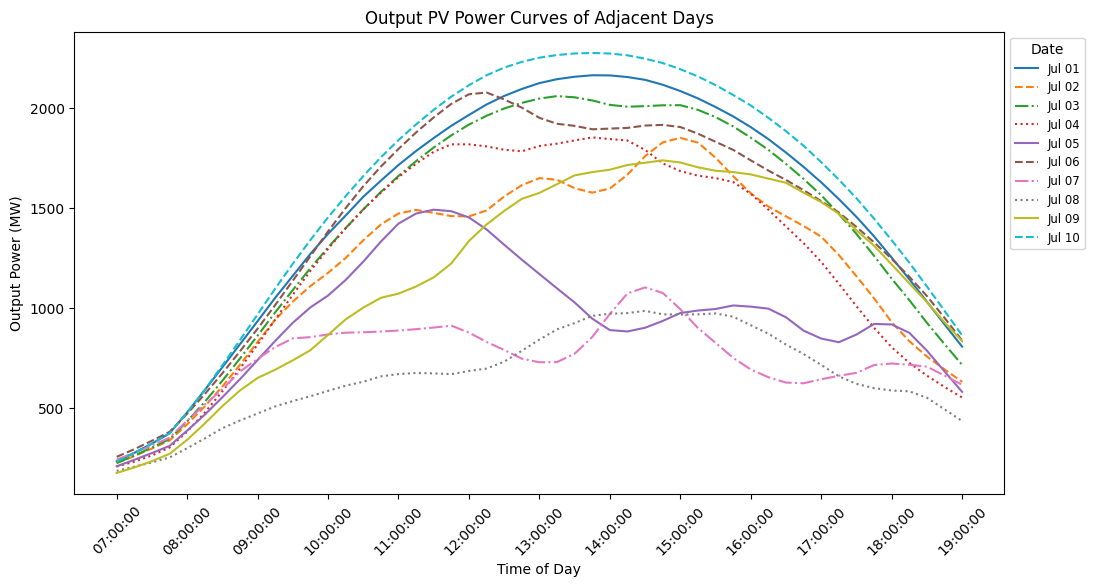

In [10]:
from itertools import cycle

# Define line styles and colors
lines = ["-", "--", "-.", ":"]
linecycler = cycle(lines)
colors = plt.cm.tab10.colors  # Define a list of colors

# Select only the first 10 days
first_10_days = selected_days[:10]
df_subset_10days = df[df["Date"].isin(first_10_days)]

# Filter the dataframe to include only rows where the time is between 07:00:00 and 19:00:00
df_subset_10days = df_subset_10days[(df_subset_10days["Time"] >= "07:00:00") & (df_subset_10days["Time"] <= "19:00:00")]

# Pivot data to have time on x-axis and days as separate lines
pivot_df = df_subset_10days.pivot(index="Time", columns="Date", values="Real_Time_Measurement_MW")

# Apply rolling mean to smooth the data
pivot_df = pivot_df.rolling(window=4, min_periods=1).mean()  # Increased window size for smoother plot

# Plot Figure 2: Output PV Power Curves of Adjacent Days (All Time)
plt.figure(figsize=(12, 6))
for i, day in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[day], label=day.strftime('%b %d'), linestyle=next(linecycler), color=colors[i % len(colors)])

# Formatting the plot
plt.xlabel("Time of Day")
plt.ylabel("Output Power (MW)")
plt.title("Output PV Power Curves of Adjacent Days")
plt.xticks(pivot_df.index[::4], rotation=45)  # Show time every 1 hour (4 * 15 minutes = 1 hour)
plt.legend(title="Date", bbox_to_anchor=(1, 1), loc="upper left", fontsize='small')  # Adjust font size

# Show the plot
plt.show()

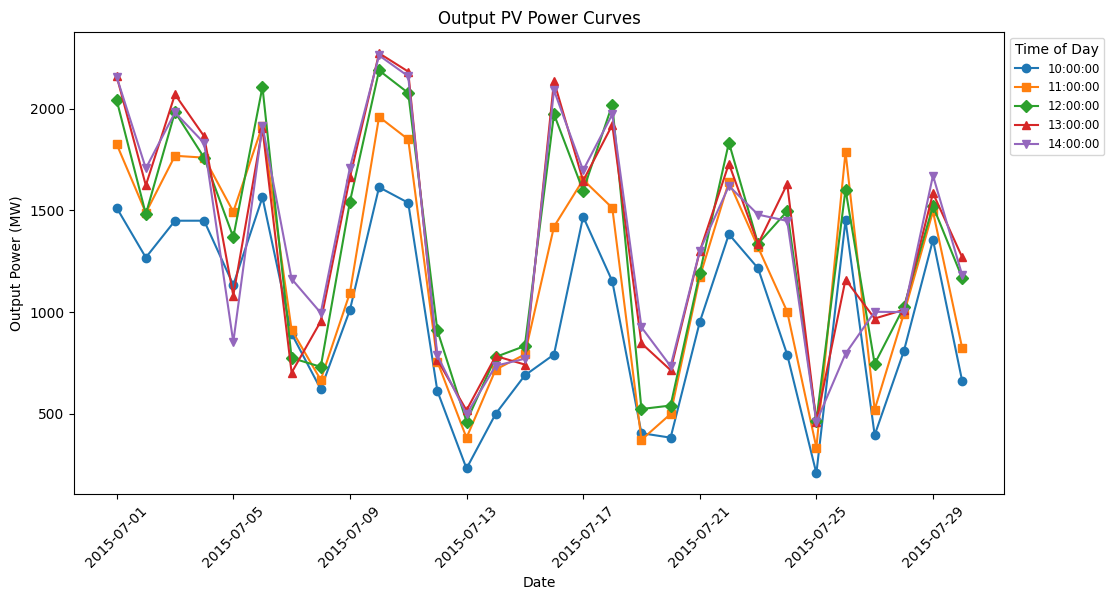

In [11]:
from itertools import cycle

# Define markers
markers = cycle(['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h'])

# Select a range of days (e.g., day 1 to day 30)
start_day = 1
end_day = 30
selected_days_range = selected_days[start_day-1:end_day]

# Select a time range (e.g., 10:00:00 to 14:00:00)
start_time = "10:00:00"
end_time = "14:00:00"

# Filter the dataframe to include only rows where the date is within the selected range
df_subset_range = df[df["Date"].isin(selected_days_range)]

# Filter the dataframe to include only rows where the time is within the selected range and ends with ':00:00'
df_subset_range = df_subset_range[(df_subset_range["Time"] >= start_time) & (df_subset_range["Time"] <= end_time) & df_subset_range["Time"].str.endswith(':00:00')]

# Use time on line and date on y-axis
pivot_df = df_subset_range.pivot(index="Date", columns="Time", values="Real_Time_Measurement_MW")

# Plot Figure 3: Output PV Power Curves of Adjacent Hours
plt.figure(figsize=(12, 6))
for time in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[time], label=time, marker=next(markers))

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Output Power (MW)")
plt.title(f"Output PV Power Curves")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title="Time of Day", bbox_to_anchor=(1, 1), loc="upper left", fontsize='small')  # Adjust font size

# Show the plot
plt.show()

In [12]:
#select Real_Time_Measurement_MW column to show info
df["Real_Time_Measurement_MW"].describe()

count    2976.000000
mean      521.820914
std       625.796375
min         0.000000
25%         0.000000
50%       233.680000
75%       900.217500
max      2280.210000
Name: Real_Time_Measurement_MW, dtype: float64